# Install Dependencies

In [1]:
!pip install netCDF4 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00


# Fetch the data & plot

In [5]:
from netCDF4 import Dataset, num2date
import requests
import tempfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import date2num

def fetch_and_plot(server_url, dataset_id, start_date, end_date, depth_range, height_per_plot, color_pallete, arrow_head, output_filename, instrument=0):

    url = f'{server_url}/tabledap/{dataset_id}.nc?time,latitude,longitude,platform,depth,sea_water_speed_{instrument},sea_water_direction_{instrument}&time>={start_date}&time<={end_date}'

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the response is valid
    if response.status_code != 200:
        print(f"Failed to fetch data. HTTP status code: {response.status_code}")
        return

    # Create a temporary file to store the content of the response
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        tmp_file.write(response.content)
        tmp_file.seek(0)  # Reset the file pointer

        try:
            # Open the NetCDF dataset
            nc = Dataset(tmp_file.name)
        except OSError as e:
            print(f"Failed to open NetCDF file: {e}")
            return

        # Extract data for the variables
        time = nc.variables['time'][:]

        time_units = nc.variables['time'].units
        time_dates = num2date(time, units=time_units)
        depth = nc.variables['depth'][:]
        sea_water_speed = nc.variables[f'sea_water_speed_{instrument}'][:]
        sea_water_direction = nc.variables[f'sea_water_direction_{instrument}'][:]

        # Create DataFrame
        df = pd.DataFrame({
            'time': time_dates,
            # 'latitude': latitude,
            # 'longitude': longitude,
            'depth': depth,
            f'sea_water_speed_{instrument}': sea_water_speed,
            f'sea_water_direction_{instrument}': sea_water_direction
        })

        # Filter data by date range
        df = df[(df['time'] >= pd.to_datetime(start_date)) & (df['time'] <= pd.to_datetime(end_date))]
        df[f'sea_water_speed_{instrument}'] /= 100.0  # Convert cm/s to m/s

        df = df.dropna(subset=[f'sea_water_speed_{instrument}', f'sea_water_direction_{instrument}'])

        if df.empty:
            print(f"No data available for depths between {depth_range[0]} m and {depth_range[1]} m for {dataset_id}")
            return

        df = df[(df['depth'] >= depth_range[0]) & (df['depth'] <= depth_range[1])]

        global_min_time = date2num(df['time'].min())
        global_max_time = date2num(df['time'].max())

        unique_depths = sorted(df['depth'].unique(), reverse=True)
        plot_height_per_depth = height_per_plot
        total_height = plot_height_per_depth * len(unique_depths)

        fig, ax = plt.subplots(figsize=(20, total_height))

        y_offset_factor = 10.0

        for i, depth in enumerate(unique_depths):
            subset = df[df['depth'] == depth]
            times = subset['time']
            speeds = subset[f'sea_water_speed_{instrument}']
            directions = subset[f'sea_water_direction_{instrument}']

            directions_rad = np.radians(directions)
            u = speeds * np.sin(directions_rad)
            v = speeds * np.cos(directions_rad)

            colors = np.where(speeds <= 0.10, color_pallete[0],
                              np.where(speeds <= 0.20, color_pallete[1],
                                       np.where(speeds <= 0.30, color_pallete[2],
                                                np.where(speeds <= 0.40, color_pallete[3],
                                                         np.where(speeds <= 0.50, color_pallete[4], color_pallete[5])))))

            if arrow_head:
                ax.quiver(date2num(times), np.full_like(times, i * y_offset_factor), u, v,
                          color=colors, scale=20, width=0.002, headlength=2, headwidth=2, headaxislength=2.5)
            else:
                ax.quiver(date2num(times), np.full_like(times, i * y_offset_factor), u, v,
                          color=colors, scale=20, width=0.001, headlength=0, headwidth=0, headaxislength=0)

            annotation_x_position = global_min_time - 0.15
            ax.text(annotation_x_position, i * y_offset_factor, f'{depth} m', horizontalalignment='right', verticalalignment='center', color="black")

        ax.set_xlim(annotation_x_position, global_max_time + 0.2)
        ax.set_ylim(-y_offset_factor, (len(unique_depths) - 1) * y_offset_factor + y_offset_factor)
        ax.axes.get_yaxis().set_visible(False)  # Hide y-axis
        ax.xaxis_date()

        plt.title(f'Stick Plot for Depths from {depth_range[0]} m to {depth_range[1]} m for {dataset_id}')
        plt.xticks(rotation=45)
        plt.draw()  # Ensure all elements are drawn

        plt.savefig(output_filename, dpi=300)  # Save the figure
        plt.show()



# Usage example with configurable parameters

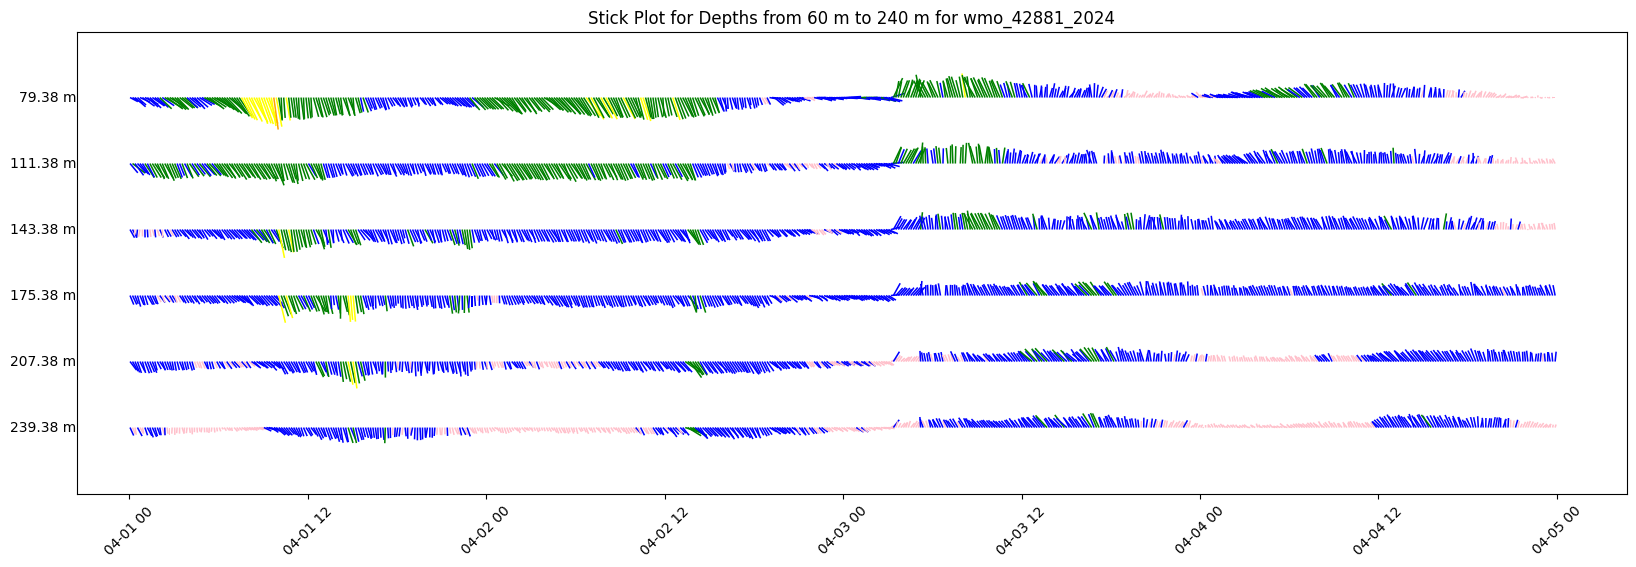

In [6]:
# Usage example with instrument parameter:
fetch_and_plot(
    server_url="https://erddap.gcoos.org/erddap",
    dataset_id="wmo_42881_2024",
    start_date="2024-04-01 00:00:00",
    end_date="2024-04-05 00:00:00",
    height_per_plot=1.0, #spacing between the stick plots
    arrow_head=False,
    color_pallete=['pink', 'blue', 'green', 'yellow', 'orange', 'red'],
    output_filename="plot_output_2d.png",
    depth_range=(60, 240),  # Depth range in meters
    instrument=1  # Configurable instrument number
)